# Utilities

In [1]:
import torch


'''
Colorspace tools
Taken from https://github.com/limacv/RGB_HSV_HSL
'''

def rgb2hsl_torch(rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsl_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsl_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsl_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsl_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsl_h[cmax_idx == 3] = 0.
    hsl_h /= 6.

    hsl_l = (cmax + cmin) / 2.
    hsl_s = torch.empty_like(hsl_h)
    hsl_s[hsl_l == 0] = 0
    hsl_s[hsl_l == 1] = 0
    hsl_l_ma = torch.bitwise_and(hsl_l > 0, hsl_l < 1)
    hsl_l_s0_5 = torch.bitwise_and(hsl_l_ma, hsl_l <= 0.5)
    hsl_l_l0_5 = torch.bitwise_and(hsl_l_ma, hsl_l > 0.5)
    hsl_s[hsl_l_s0_5] = ((cmax - cmin) / (hsl_l * 2.))[hsl_l_s0_5]
    hsl_s[hsl_l_l0_5] = ((cmax - cmin) / (- hsl_l * 2. + 2.))[hsl_l_l0_5]
    return torch.cat([hsl_h, hsl_s, hsl_l], dim=1)


def rgb2hsv_torch(rgb: torch.Tensor) -> torch.Tensor:
    cmax, cmax_idx = torch.max(rgb, dim=1, keepdim=True)
    cmin = torch.min(rgb, dim=1, keepdim=True)[0]
    delta = cmax - cmin
    hsv_h = torch.empty_like(rgb[:, 0:1, :, :])
    cmax_idx[delta == 0] = 3
    hsv_h[cmax_idx == 0] = (((rgb[:, 1:2] - rgb[:, 2:3]) / delta) % 6)[cmax_idx == 0]
    hsv_h[cmax_idx == 1] = (((rgb[:, 2:3] - rgb[:, 0:1]) / delta) + 2)[cmax_idx == 1]
    hsv_h[cmax_idx == 2] = (((rgb[:, 0:1] - rgb[:, 1:2]) / delta) + 4)[cmax_idx == 2]
    hsv_h[cmax_idx == 3] = 0.
    hsv_h /= 6.
    hsv_s = torch.where(cmax == 0, torch.tensor(0.).type_as(rgb), delta / cmax)
    hsv_v = cmax
    return torch.cat([hsv_h, hsv_s, hsv_v], dim=1)


def hsv2rgb_torch(hsv: torch.Tensor) -> torch.Tensor:
    hsv_h, hsv_s, hsv_l = hsv[:, 0:1], hsv[:, 1:2], hsv[:, 2:3]
    _c = hsv_l * hsv_s
    _x = _c * (- torch.abs(hsv_h * 6. % 2. - 1) + 1.)
    _m = hsv_l - _c
    _o = torch.zeros_like(_c)
    idx = (hsv_h * 6.).type(torch.uint8)
    idx = (idx % 6).expand(-1, 3, -1, -1)
    rgb = torch.empty_like(hsv)
    rgb[idx == 0] = torch.cat([_c, _x, _o], dim=1)[idx == 0]
    rgb[idx == 1] = torch.cat([_x, _c, _o], dim=1)[idx == 1]
    rgb[idx == 2] = torch.cat([_o, _c, _x], dim=1)[idx == 2]
    rgb[idx == 3] = torch.cat([_o, _x, _c], dim=1)[idx == 3]
    rgb[idx == 4] = torch.cat([_x, _o, _c], dim=1)[idx == 4]
    rgb[idx == 5] = torch.cat([_c, _o, _x], dim=1)[idx == 5]
    rgb += _m
    return rgb


def hsl2rgb_torch(hsl: torch.Tensor) -> torch.Tensor:
    hsl_h, hsl_s, hsl_l = hsl[:, 0:1], hsl[:, 1:2], hsl[:, 2:3]
    _c = (-torch.abs(hsl_l * 2. - 1.) + 1) * hsl_s
    _x = _c * (-torch.abs(hsl_h * 6. % 2. - 1) + 1.)
    _m = hsl_l - _c / 2.
    idx = (hsl_h * 6.).type(torch.uint8)
    idx = (idx % 6).expand(-1, 3, -1, -1)
    rgb = torch.empty_like(hsl)
    _o = torch.zeros_like(_c)
    rgb[idx == 0] = torch.cat([_c, _x, _o], dim=1)[idx == 0]
    rgb[idx == 1] = torch.cat([_x, _c, _o], dim=1)[idx == 1]
    rgb[idx == 2] = torch.cat([_o, _c, _x], dim=1)[idx == 2]
    rgb[idx == 3] = torch.cat([_o, _x, _c], dim=1)[idx == 3]
    rgb[idx == 4] = torch.cat([_x, _o, _c], dim=1)[idx == 4]
    rgb[idx == 5] = torch.cat([_c, _o, _x], dim=1)[idx == 5]
    rgb += _m
    return rgb

# Load rfom NuScenes

In [37]:
# Modified from huggingface  
from huggingface_hub import hf_hub_download
from ipywidgets import Video

# file_path = hf_hub_download(
#     repo_id="nielsr/video-demo", filename="eating_spaghetti.mp4", repo_type="dataset"
# )
# Video.from_file(file_path, width=64)

file_path = '/home/akirchme/coursework/16824/project/nuscenes-devkit/output/0c3833f73f0e43288758cb87c9d2a4fe.mp4'
file_path = '/home/akirchme/coursework/16824/project/nuscenes-devkit/output/0ba56cee062b419a80a6a90302944c19.mp4'


from decord import VideoReader, cpu
import numpy as np

np.random.seed(0)

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len+1)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

vr = VideoReader(file_path, num_threads=1, ctx=cpu(0))

# sample 16 frames
vr.seek(0)
clip_len = len(vr)
indices = sample_frame_indices(clip_len=clip_len, frame_sample_rate=1, seg_len=len(vr))
video = vr.get_batch(indices).asnumpy()
print(video.shape)
images = torch.Tensor(video).permute((0,3,1,2))/255
vid = 'NU1'

Video.from_file(file_path)

(10, 512, 512, 3)


Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x02\x92\x7f...')

# Load from Rear Signal Dataset

In [8]:
import cv2
import os
from tqdm import tqdm 
import numpy as np
from torchvision.transforms.functional import resize

def load_images_from_folder(folder, size=(64,64)):
    images = []
    for filename in tqdm(sorted(os.listdir(folder))):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(resize(torch.Tensor(img).permute((2,0,1)), size))
    return images

if True:
    vid = 'RSD1'
    file_path = '/home/akirchme/coursework/16824/project/yolov7/dataset/rear_signal_dataset/test-02-26-2016_10-49-42/test-02-26-2016_10-49-42_BLO/test-02-26-2016_10-49-42_BLO_2909/light_mask'
if False:
    vid = 'RSD2'
    file_path = '/home/akirchme/coursework/16824/project/yolov7/dataset/rear_signal_dataset/test-02-26-2016_11-47-25/test-02-26-2016_11-47-25_OOR/test-02-26-2016_11-47-25_OOR_2951/light_mask'
if False:
    vid = 'RSD3'
    file_path = '/home/akirchme/coursework/16824/project/yolov7/dataset/rear_signal_dataset/test-02-26-2016_11-47-25/test-02-26-2016_11-47-25_BOR/test-02-26-2016_11-47-25_BOR_2887/light_mask'
if False:
    vid = 'RSD4'
    file_path = '/home/akirchme/coursework/16824/project/yolov7/dataset/rear_signal_dataset/test-02-26-2016_11-12-02/test-02-26-2016_11-12-02_OOO/test-02-26-2016_11-12-02_OOO_11117/light_mask'
if False:
    vid = 'NU1'
    file_path = './data/samples/CAM_FRONT'
images = torch.stack(load_images_from_folder(file_path)).float()/255#.permute((0,2,3,1))
images.shape

100%|███████████████████████████████████████████████████████████████████████████| 358/358 [00:01<00:00, 241.10it/s]


torch.Size([358, 3, 64, 64])

# Statistical approach

torch.Size([358, 3, 64, 64]) torch.Size([358, 3, 64, 64]) torch.Size([358, 3, 64, 64])


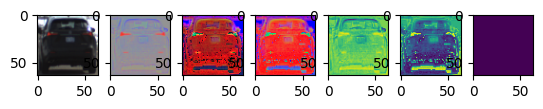

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation as animation
import numpy as np

yellow = torch.Tensor(np.array([1,1,0])).reshape(1,3,1,1)#/(2**0.5)
yellow_hsv = rgb2hsv_torch(yellow)
yellow_h = yellow_hsv[:,0,:,:]

#images = images.permute((0,3,1,2))
hsv_images = rgb2hsv_torch(images).float()
eps = 1e-9
hsv_norm_images = hsv_images/(hsv_images+eps).float().norm(dim=1, keepdim=True)
norm_images = images/(images+eps).norm(dim=1, keepdim=True)
print(images.shape, hsv_images.shape, hsv_norm_images.shape)


proj = (images*yellow/yellow.norm()).sum(dim=1)
proj = proj/proj.max()
proj_hsv = (hsv_images*yellow_hsv/yellow_hsv.norm()).sum(dim=1)
proj_hsv = proj_hsv/proj_hsv.max()
proj_v = hsv_images[:,2]/hsv_images[:,2].max()
corr = (norm_images*yellow/yellow.norm()).sum(dim=1)
corr = (corr - corr.mean(dim=[1,2]).reshape(-1,1,1))/corr.std(dim=[1,2]).reshape(-1,1,1)
corr_hsv = (hsv_norm_images*yellow_hsv/yellow_hsv.norm()).sum(dim=1)
corr_hsv = (corr_hsv - corr_hsv.mean())/corr_hsv.std()
proj_diff = proj[1:]-proj[:-1]
proj_diff = (proj_diff - proj_diff.min()) / (proj_diff.max() - proj_diff.min())
trig = corr >= 3

fig, axs = plt.subplots(ncols=7)
axs[0].imshow(images[0].permute((1,2,0)))
axs[1].imshow(norm_images[0].permute((1,2,0)))
axs[2].imshow(hsv_images[0].permute((1,2,0)))
axs[3].imshow(hsv_norm_images[0].permute((1,2,0)))
axs[4].imshow(corr[0])
axs[5].imshow(corr_hsv[0])
axs[6].imshow(trig[0])
plt.show()

n_frames = min(len(images), 32)


## Generate GIFs 

KeyboardInterrupt: 

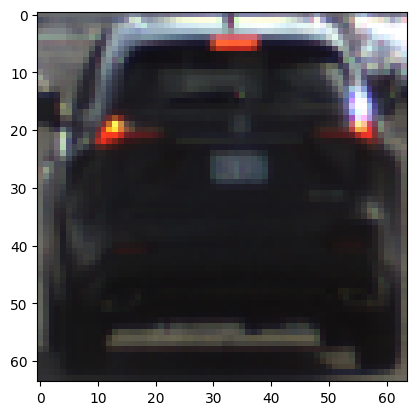

In [48]:
fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*trig[i]).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_trig.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*images[i]).byte().permute((1,2,0)).numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*hsv_images[i]).permute((1,2,0)).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_hsv.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*norm_images[i]).permute((1,2,0)).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_norm.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*hsv_norm_images[i]).permute((1,2,0)).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_hsv_norm.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*proj[i]).unsqueeze(-1).repeat(1,1,3).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_proj.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*proj_hsv[i]).unsqueeze(-1).repeat(1,1,3).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_proj_hsv.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*proj_v[i]).unsqueeze(-1).repeat(1,1,3).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_proj_v.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*corr[i]).unsqueeze(-1).repeat(1,1,3).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_corr.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

fig, ax = plt.subplots()
animate = lambda i: ax.imshow((255*corr_hsv[i]).unsqueeze(-1).repeat(1,1,3).byte().numpy())
ani = animation.FuncAnimation(fig, animate, frames=n_frames)
f = f"{vid}_clip_corr_hsv.gif" 
writergif = animation.PillowWriter(fps=8) 
ani.save(f, writer=writergif)
plt.show()

## Qualitative Analysis

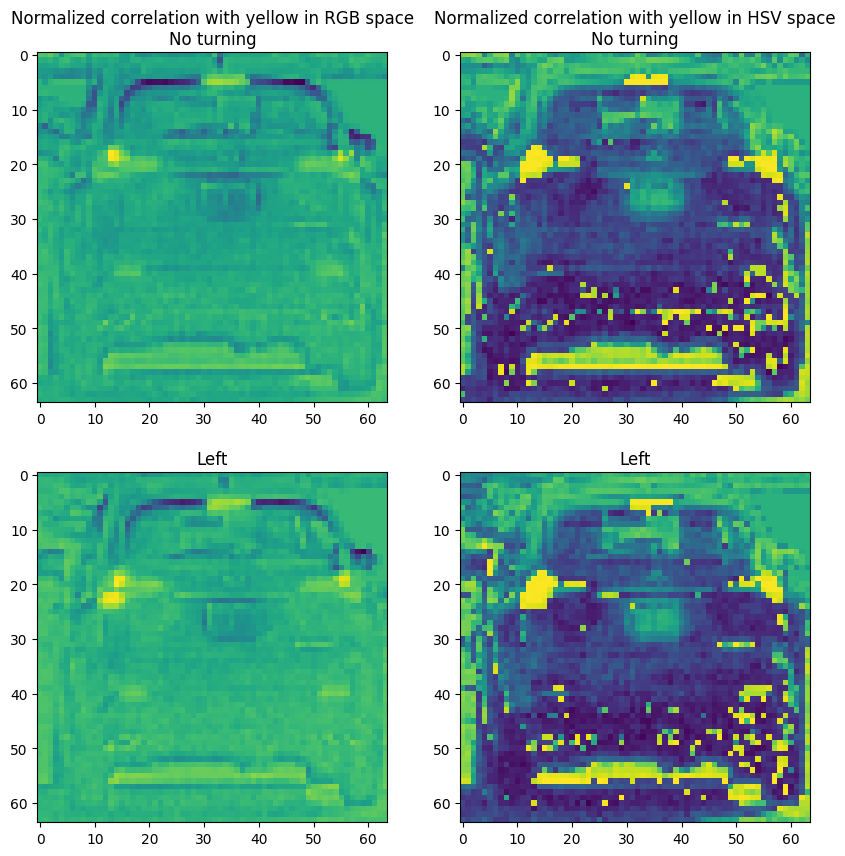

In [107]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10,10))
axs[0,0].imshow(corr[1])
axs[0,1].imshow(corr_hsv[1])
axs[1,0].imshow(corr[5])
axs[1,1].imshow(corr_hsv[5])
axs[0,0].set_title('Normalized correlation with yellow in RGB space\nNo turning')
axs[0,1].set_title('Normalized correlation with yellow in HSV space\nNo turning')
axs[1,0].set_title('Left')
axs[1,1].set_title('Left')
plt.show()

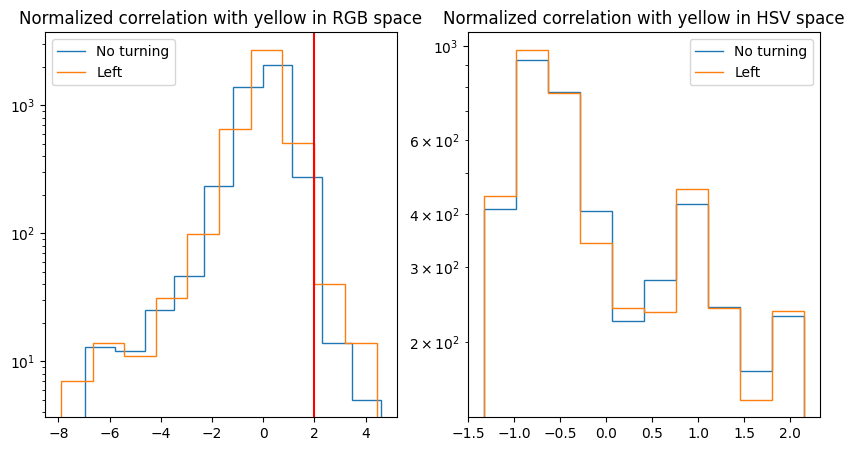

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
counts1, bins1 = np.histogram(corr[1])
counts2, bins2 = np.histogram(corr_hsv[1])
counts3, bins3 = np.histogram(corr[5])
counts4, bins4 = np.histogram(corr_hsv[5])
axs[0].stairs(counts1, bins1, label='No turning')
axs[0].stairs(counts3, bins3, label='Left')
axs[1].stairs(counts2, bins2, label='No turning')
axs[1].stairs(counts4, bins4, label='Left')

axs[0].set_title('Normalized correlation with yellow in RGB space')
axs[1].set_title('Normalized correlation with yellow in HSV space')
axs[0].axvline(x=2, color='red')
axs[0].set_yscale('log')
axs[1].set_yscale('log')
axs[0].legend()
axs[1].legend()

# X-CLIP

In [15]:
from transformers import XCLIPProcessor, XCLIPModel
import torch

n_frames = 8
if n_frames == 8:
    model_name = "microsoft/xclip-base-patch32"
else:
    model_name = "microsoft/xclip-base-patch16-16-frames"
processor = XCLIPProcessor.from_pretrained(model_name)
model = XCLIPModel.from_pretrained(model_name).cuda()
verbose = True


feats = {
    "left": [
        "left yellow light on", "left yellow light off",
        "left taillight on", "left taillight off",
        "left headlight on", "left headlight off"
    ],
    "right": [
        "right yellow light on", "right yellow light off",
        "right taillight on", "right taillight off",
        "right headlight on", "right headlight off",
    ],
    "brake": [
        "brakelight on", "brakelight off",
        "stoplight on", "stoplight off",
        "red light on", "red light off",
    ],
    "blink-left": [
        "left blinking light", "no blinking light",
        "left yellow blinking light", "no yellow blinking light",
        "left red blinking light", "no red blinking light",
    ],
    "blink-right": [
        "right blinking light",  "no blinking light",
        "right yellow blinking light", "no yellow blinking light",
        "right red blinking light", "no red blinking light",
    ],
    "presence": [
        "yellow light on", "yellow light off", 
        "red light on", "red light off"
    ],
    "count": [
        "many lights on", "two lights on", "one light on", "no light"
    ]
}


left, right, brake, bleft, bright = [], [], [], [], []
both = []
for i in tqdm(range(0, len(images), 1)):
    if i+n_frames > len(images):
        break
    video = torch.Tensor(images[i:i+n_frames]).byte().cuda()
    inputs = processor(text=feats, videos=list(video), return_tensors="pt", padding=True)
    inputs = {k:v.cuda() for k,v in inputs.items()}
    #inputs['pixel_values'] = inputs['pixel_values'].cuda()
    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
    probs = outputs.logits_per_video.reshape(len(feats)//2, 2).softmax(dim=1)
    probs = torch.round(probs, decimals=3).cpu().detach()

    left.append(probs[:3,0])
    right.append(probs[3:6,0])
    brake.append(probs[6:9,0])
    bleft.append(probs[9:12,0])
    bright.append(probs[12:15,0])
    both.append(probs[15:17,0])
# if verbose:
#     print("left\n", probs[:3])
#     print("right\n", probs[3:6])
#     print("brake\n", probs[6:9])
#     print("blink-left\n", probs[9:12])
#     print("blink-right\n", probs[12:15])
#     if verbose:
#         print("left", torch.stack(left).mean().item())
#         print("right", torch.stack(right).mean().item())
#         print("brake", torch.stack(brake).mean().item())
#         print("blink-left", torch.stack(bleft).mean().item())
#         print("blink-right", torch.stack(bright).mean().item())

2023-05-04 22:28:44.374789: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 22:28:45.357060: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akirchme/.conda/envs/diff2/lib/python3.10/site-packages/cv2/../../lib64:
2023-05-04 22:28:45.357160: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akirchme/.conda/envs/diff2/lib/python3.10/sit

In [14]:
left = torch.stack(left)
right = torch.stack(right)
brake = torch.stack(brake)
bleft = torch.stack(bleft)
bright = torch.stack(bright)
both = torch.stack(both)

left.shape

NameError: name 'left' is not defined

Text(0.5, 1.0, 'RSD3 8-frames')

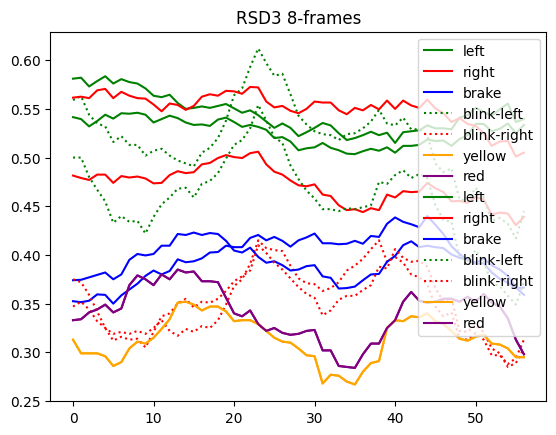

In [309]:
for i in range(0, 3):
    plt.plot(range(left.shape[0]), left[:,i:(i+2)].mean(axis=1), label='left', color='green')
    plt.plot(range(right.shape[0]), right[:,i:(i+2)].mean(axis=1), label='right', color='red')
    plt.plot(range(brake.shape[0]), brake[:,i:(i+2)].mean(axis=1), label='brake', color='blue')
    plt.plot(range(bleft.shape[0]), bleft[:,i:(i+1)].mean(axis=1), label='blink-left', color='green', linestyle=':')
    plt.plot(range(bright.shape[0]), bright[:,i:(i+1)].mean(axis=1), label='blink-right', color='red', linestyle=':')
    plt.plot(range(both.shape[0]), both[:,0:1].mean(axis=1), label='yellow', color='orange')
    plt.plot(range(both.shape[0]), both[:,1:2].mean(axis=1), label='red', color='purple')
plt.legend()
plt.title(f'{vid} {n_frames}-frames')

In [13]:
plt.plot(range(left.shape[0]), left.mean(axis=1), label='left', color='green')
plt.plot(range(right.shape[0]), right.mean(axis=1), label='right', color='red')
plt.plot(range(brake.shape[0]), brake.mean(axis=1), label='brake', color='blue')
plt.plot(range(bleft.shape[0]), bleft.mean(axis=1), label='blink-left', color='green', linestyle=':')
plt.plot(range(bright.shape[0]), bright.mean(axis=1), label='blink-right', color='red', linestyle=':')
    #plt.plot(range(both.shape[0]), both.mean(axis=1), label='yellow', color='orange')
    #plt.plot(range(both.shape[0]), both[:,1:2].mean(axis=1), label='red', color='purple')
plt.legend()
plt.title(f'{vid} {n_frames}-frames')

NameError: name 'left' is not defined

# Different prompts

# Blinking behavior

# Presence vs absence

# Count

In [310]:
# different parameterizations
# yellow light  vs taillight

# blinking

# different models

# rolling vs segment